In [1]:
import pandas as pd
import json
import os

In [2]:
with open('categorized_tasks-gpt-4o-retail.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,Task id,procedural,declarative,reason
0,0,Yes,Yes,The conversation involves both procedural and ...
1,1,Yes,Yes,The conversation involves both procedural and ...
2,2,Yes,Yes,The conversation involves two main tasks: SHOW...
3,3,Yes,Yes,The conversation involves two tasks: SHOW_INFO...
4,4,Yes,Yes,The conversation involves two main tasks: SHOW...


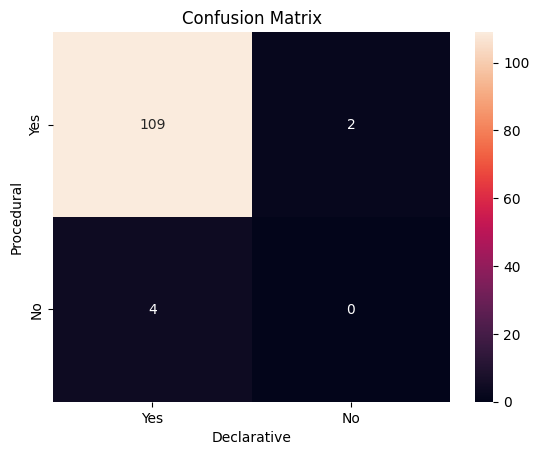

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(df['procedural'], df['declarative'], labels=['Yes', 'No'])

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Yes', 'No'], yticklabels=['Yes', 'No'])
plt.xlabel('Declarative')
plt.ylabel('Procedural')
plt.title('Confusion Matrix')
plt.show()

In [4]:
# Sample 5 rows for each combination of procedural and declarative
sampled_df = df.groupby(['procedural', 'declarative']).apply(lambda x: x.sample(n=5, random_state=2) if len(x) >= 5 else x).reset_index(drop=True)
sampled_df

/var/folders/nr/1tw88k6s4xg8ng602yz6f4h00000gn/T/ipykernel_33546/2254232767.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(['procedural', 'declarative']).apply(lambda x: x.sample(n=5, random_state=2) if len(x) >= 5 else x).reset_index(drop=True)


,Task id,procedural,declarative,reason
0,50,No,Yes,The conversation is primarily declarative as t...
1,56,No,Yes,The task in the conversation is to check the d...
2,67,No,Yes,The task in this conversation is primarily abo...
3,68,No,Yes,The task in this conversation is to retrieve i...
4,22,Yes,No,The conversation involves multiple tasks where...
5,103,Yes,No,The conversation involves multiple tasks where...
6,14,Yes,Yes,The conversation involves both procedural and ...
7,13,Yes,Yes,The conversation involves both procedural and ...
8,21,Yes,Yes,The conversation involves multiple tasks: 1) E...
9,2,Yes,Yes,The conversation involves two main tasks: SHOW...


In [5]:
df["group"] = "P_" + df["procedural"] + "-" + "D_" + df["declarative"]

In [6]:
with open("/Users/rishitoshsingh/Documents/projects/applied/tau-bench/historical_trajectories/gpt-4o-retail.json", 'r') as f:
    original_data = json.load(f)

In [7]:
df.dtypes

Task id         int64
procedural     object
declarative    object
reason         object
group          object
dtype: object

In [8]:
original_df = pd.DataFrame(original_data)
original_df.drop_duplicates(subset=["task_id"], inplace=True)
original_df.drop(columns=["traj"], inplace=True)
original_df

,task_id,reward,info,trial
0,0,1.0,"{'task': {'user_id': 'yusuf_rossi_9620', 'acti...",0
1,1,1.0,"{'task': {'user_id': 'yusuf_rossi_9620', 'acti...",0
2,2,1.0,"{'task': {'user_id': 'yusuf_rossi_9620', 'acti...",0
3,3,1.0,"{'task': {'user_id': 'yusuf_rossi_9620', 'acti...",0
4,4,1.0,"{'task': {'user_id': 'yusuf_rossi_9620', 'acti...",0
...,...,...,...,...
110,110,0.0,"{'task': {'user_id': 'sophia_martin_8570', 'ac...",0
111,111,0.0,"{'task': {'user_id': 'sophia_martin_8570', 'ac...",0
112,112,0.0,"{'task': {'user_id': 'yara_silva_7567', 'actio...",0
113,113,1.0,"{'task': {'user_id': 'yara_silva_7567', 'actio...",0


In [9]:
original_df = original_df.merge(df[["Task id","group", "reason"]], left_on="task_id", right_on="Task id", how="inner").drop(columns=["Task id"])

In [10]:
df_grouped_json = (
    df.groupby('group')
    .apply(lambda x: x.drop(columns='group').to_dict(orient='records'))
    .to_dict()
)
for key in df_grouped_json.keys():
    print(f"{key}: {len(df_grouped_json[key])} tasks")

P_No-D_Yes: 4 tasks
P_Yes-D_No: 2 tasks
P_Yes-D_Yes: 109 tasks


/var/folders/nr/1tw88k6s4xg8ng602yz6f4h00000gn/T/ipykernel_33546/130622289.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop(columns='group').to_dict(orient='records'))


In [11]:
import os
os.makedirs('final', exist_ok=True)

for key in df_grouped_json.keys():
    with open(f'final/gpt-4o-retail-{key}.json', 'w') as f:
        json.dump(df_grouped_json[key], f, indent=4)